In [4]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
import numpy as np 

In [5]:
image = cv2.imread('/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Filtered_Frames/Frame_16.png')
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


[[[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 [[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 [[100  88  81]
  [100  88  81]
  [ 99  87  80]
  ...
  [ 68  73  73]
  [ 68  73  73]
  [ 68  73  73]]

 ...

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 55  52  51]
  [ 55  52  51]
  [ 55  52  51]]

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 57  54  53]
  [ 57  54  53]
  [ 56  53  52]]

 [[ 75  78  78]
  [ 75  78  78]
  [ 75  78  78]
  ...
  [ 59  56  55]
  [ 59  56  55]
  [ 57  54  53]]]


In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [7]:
from segment_anything import build_sam, SamPredictor 
# input_box = np.array([1123.0, 589.0, 1194.0, 678.0])
input_point = np.array([[1158.5, 633.5]])
input_label = np.array([1])

In [8]:
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

0.0019208140432098765


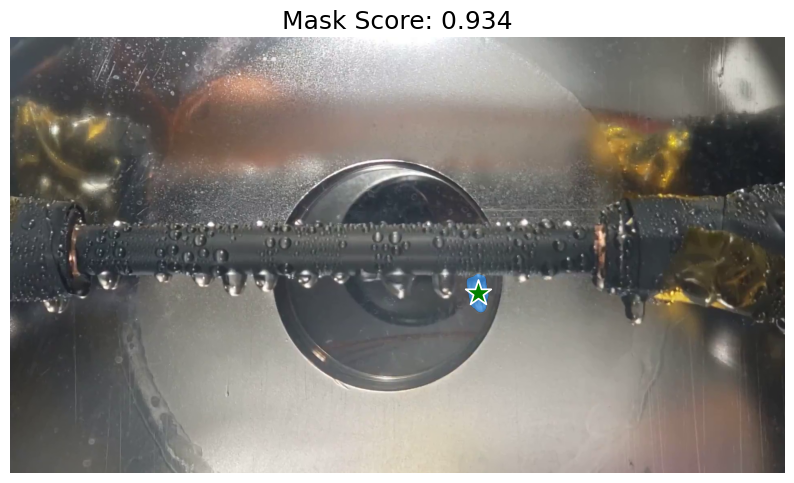

In [9]:
mask = masks[0]
score = scores[0]
positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
area = positive_pixel_count / (w*h)
print(area)

# pixels = cv2.countNonZero(mask)
# print(pixels)
# for i, (mask, score) in enumerate(zip(masks, scores)):
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show() 

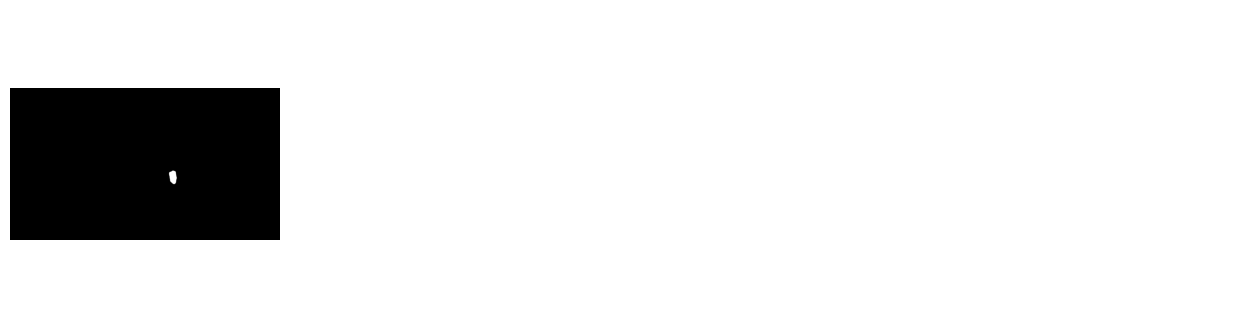

0

In [10]:
import supervision as sv

mask_bw = sv.plot_images_grid(
    images = masks,
    grid_size= (1,4),
    size = (16,4)
)

cv2.countNonZero(mask_bw)


In [11]:
def read_filtered_frames(filename):
    lines = []
    with open(filename, 'r') as file:
        for line in file:
            # Each line contains coordinates in the format: x1,y1,x2,y2
            coordinates = list(map(float, line.strip().split(',')))
            lines.append(coordinates)
    return lines

def calculate_midpoint(bbox):
    l, x1, y1, x2, y2 = bbox
    return [(x1 + x2) / 2, (y1 + y2) / 2]

def process_line(line,predictor,areas,frame_num):
    # Read frame
    # print(line)
    frame_path = f"/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/Filtered_Frames/Frame_{int(line[0])}.png"
    image = cv2.imread(frame_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate midpoint of bounding box
    bbox_midpoint = calculate_midpoint(line)
    input_point = np.array([bbox_midpoint])
    input_label = np.array([1])

    
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    mask = masks[0]
    score = scores[0]
    positive_pixel_count = mask.sum() # assumes binary mask (True == 1)
    h, w = mask.shape[-2:] # assumes NHWC data format, adapt as needed
    area = positive_pixel_count / (w*h)
    print(area)
    areas.append(area)
    frame_num.append(int(line[0]))
    # print(f"Processing frame {line} with midpoint {bbox_midpoint}")

filtered_frames_file = "/Users/hirvapatel/Documents/Semester 6-2/Project /final/Dropwise-Condensation-Project/BG_Subtraction/filtered_frames.txt"
lines = read_filtered_frames(filtered_frames_file)
predictor = SamPredictor(build_sam(checkpoint="/Users/hirvapatel/Downloads/sam_vit_h_4b8939.pth"))
areas = []
frame_num = []
for line in lines:
    process_line(line,predictor,areas,frame_num)


0.0019208140432098765
0.001976273148148148
0.0020495756172839506
0.001077835648148148
0.0019039351851851852
0.001927565586419753
0.002040895061728395
0.0023046875
0.0017255015432098765
0.0019622878086419755
0.0007846257716049383
0.0004099151234567901
0.0014115547839506173
0.002065972222222222
0.0020008680555555556
0.0004296875
0.002019675925925926
0.0021233603395061727
0.0018865740740740742
0.002113233024691358
0.00199266975308642
0.00039207175925925927
0.0008709490740740741
0.00035493827160493826
0.002083815586419753
0.0014718364197530865
0.0020707947530864195
0.0017544367283950618
0.0017963927469135802
0.001318479938271605
0.0016435185185185185
0.0004658564814814815
0.0009780092592592592
0.0002898341049382716
0.0022014853395061727
0.0005213155864197531


1080 1920


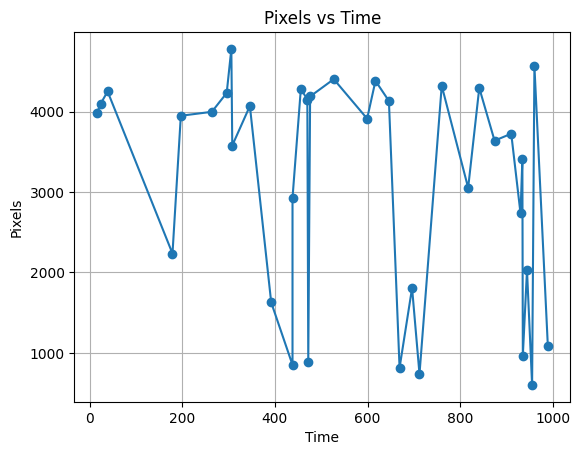

In [13]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
# Plotting the data
print(h,w)
plt.plot(frame_num, areas_np*h*w, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.title('Pixels vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()


In [14]:
def bubble_sort(arr):
    n = len(arr)
    # Traverse through all array elements
    for i in range(n):
        # Last i elements are already in place, so we don't need to check them again
        for j in range(0, n-i-1):
            # Traverse the array from 0 to n-i-1
            # Swap if the element found is greater than the next element
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]

# Example usage:
arr = [64, 34, 25, 12, 22, 11, 90]
bubble_sort(arr)
print("Sorted array:", arr)

Sorted array: [11, 12, 22, 25, 34, 64, 90]


1080 1920


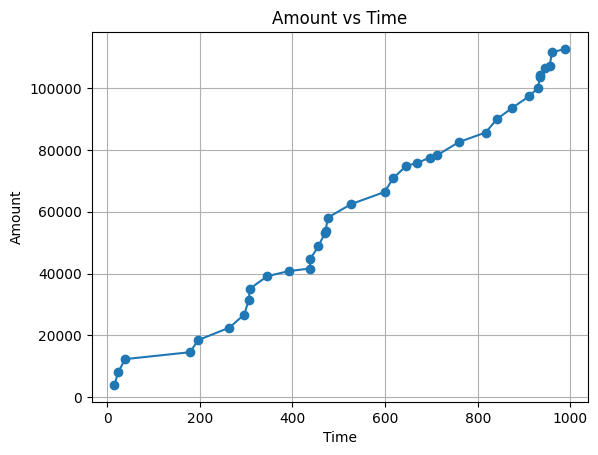

In [46]:
import matplotlib.pyplot as plt

areas_np = np.array(areas)
areas_np = areas_np*h*w

cumulative_areas = [sum(areas_np[:i+1]) for i in range(len(areas_np))]
# Plotting the data
cumulative_areas = np.array(cumulative_areas)
print(h, w)
plt.plot(frame_num, cumulative_areas, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Amount vs Time')

# Displaying the plot
plt.grid(True)  # Enable grid
plt.show()

In [17]:
image = cv2.imread('Filtered_Frames/Frame_16.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

max_y = 0

if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        if (y2==462 or y2==589) and (theta<1.6 and theta>1.57):
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display the image with detected lines
cv2.imwrite('image_with_detected_lines.jpg', image)

True

In [32]:
rod_upper = 462
rod_lower = 589
rod_diameter = rod_lower-rod_upper
rod_dia_mm = 0.3 #Needs to be changed
per_pix_len = rod_dia_mm/rod_diameter

In [48]:
def get_mass(area_in_px2, density):
    area = area_in_px2*(per_pix_len**2)
    vol = (4/3)*(np.pi**(-1/2))*(area**1.5)
    return vol*density

In [70]:
def mass_time_graph(cum_mass, frame_num, frame_rate):
    frame_num = np.array(frame_num)
    time = frame_num/frame_rate
    plt.plot(time, cum_mass, marker='o')
    plt.xlabel('Time (in sec.)')
    plt.ylabel('Mass (in gram)')
    plt.title('Mass of Water falling vs Time')
    # Displaying the plot
    plt.grid(True)  # Enable grid
    plt.show()

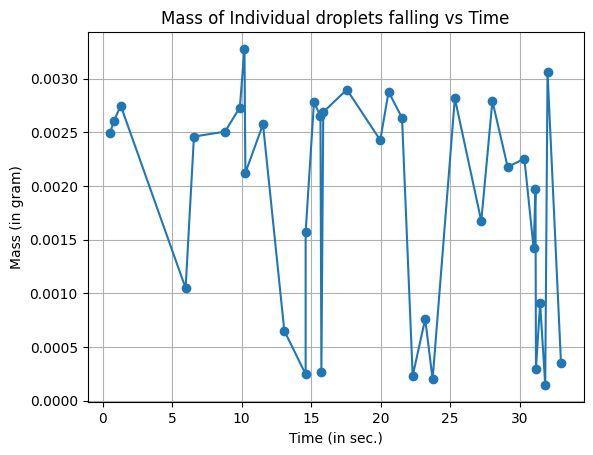

In [69]:
cum_mass = get_mass(areas_np,1) 
mass_time_graph(cum_mass, frame_num, 30)

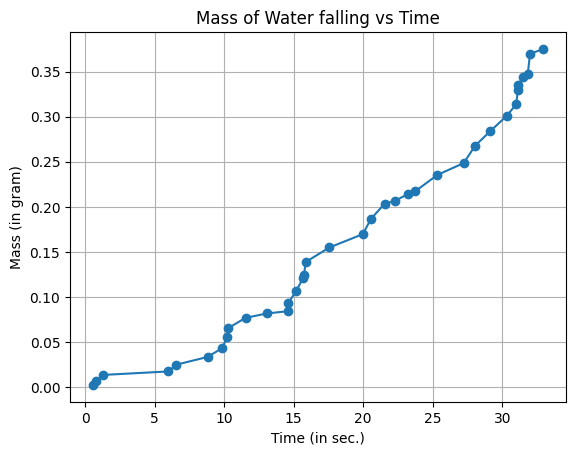

In [71]:
# cumulative_areas = np.array(cumulative_areas)
cum_mass = get_mass(cumulative_areas,1) 
mass_time_graph(cum_mass, frame_num, 30)

In [75]:
def calculate_slope(x1, y1, x2, y2):
    delta_y = y2 - y1
    delta_x = x2 - x1
    if delta_x == 0:
        return None  # Avoid division by zero
    slope = delta_y / delta_x
    return slope

# Sample x and y values for 20 data points
x_values = frame_num
y_values = cumulative_areas

# Calculate the slope for each pair of points
slopes = []
for i in range(len(x_values) - 15):
    slope = calculate_slope(x_values[i], y_values[i], x_values[i + 15], y_values[i + 15])
    if slope is not None:  # Check if slope is a number
        slopes.append(slope)

# Average the slopes
average_slope = sum(slopes) / len(slopes)

print("No. of Slopes:", len(slopes))
print("Average Slope:", average_slope)

No. of Slopes: 21
Average Slope: 112.97260309314305


In [76]:
import csv

data = list(zip(frame_num,cumulative_areas))

csv_file = "cumulative_area_data.csv"

# Write the data to a CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Time (in secs)','Mass (in gms)'])  # Write header
    writer.writerows(data)